In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load California Housing dataset as our population dataset
# This contains population info along with other demographic variables
print("Loading California Housing dataset...")
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
print(f"Dataset shape: {data.shape}")
print("\nFeatures in the dataset:")
for i, feature in enumerate(california.feature_names):
    print(f"{i+1}. {feature}")

# Prepare the dataset for clustering
print("\nPreparing data for clustering...")
# We'll use MedInc (median income), AveRooms, AveBedrms, Population, AveOccup
# These features are related to demographics and population
features_to_use = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X = data[features_to_use].copy()

print("\nData sample:")
print(X.head())

print("\nData statistics:")
print(X.describe())

# Check for missing values
print("\nMissing values:")
print(X.isnull().sum())

# Standardize the features
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

Loading California Housing dataset...
Dataset shape: (20640, 8)

Features in the dataset:
1. MedInc
2. HouseAge
3. AveRooms
4. AveBedrms
5. Population
6. AveOccup
7. Latitude
8. Longitude

Preparing data for clustering...

Data sample:
   MedInc  AveRooms  AveBedrms  Population  AveOccup
0  8.3252  6.984127   1.023810       322.0  2.555556
1  8.3014  6.238137   0.971880      2401.0  2.109842
2  7.2574  8.288136   1.073446       496.0  2.802260
3  5.6431  5.817352   1.073059       558.0  2.547945
4  3.8462  6.281853   1.081081       565.0  2.181467

Data statistics:
             MedInc      AveRooms     AveBedrms    Population      AveOccup
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000
mean       3.870671      5.429000      1.096675   1425.476744      3.070655
std        1.899822      2.474173      0.473911   1132.462122     10.386050
min        0.499900      0.846154      0.333333      3.000000      0.692308
25%        2.563400      4.440716      1.006079 


Reducing dimensionality with PCA for visualization...


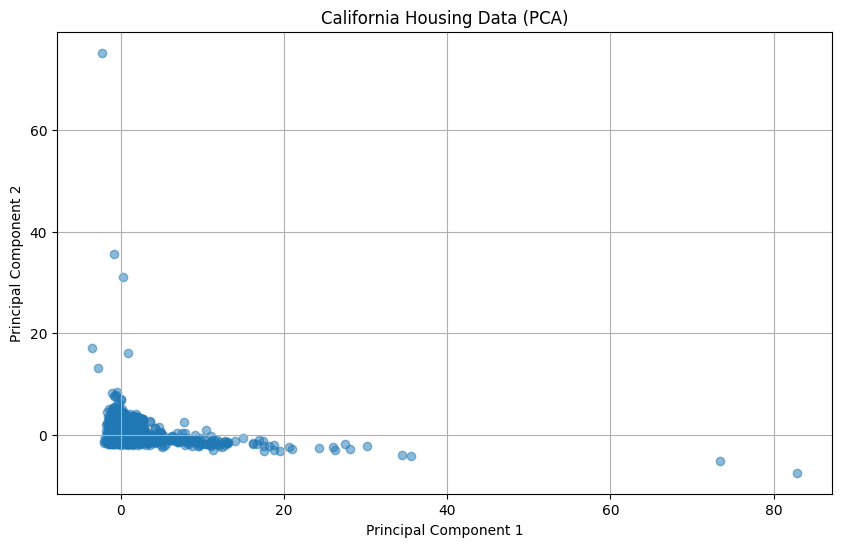

In [3]:
# Reduce dimensionality for visualization
print("\nReducing dimensionality with PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Visualize the original data in 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('California Housing Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.savefig('original_data_pca.png')

In [4]:
# Function to evaluate clustering performance
def evaluate_clustering(X, labels, model_name):
    metrics = {}
    
    # Only calculate silhouette if we have more than one cluster and not all points are noise
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:
        metrics['silhouette'] = silhouette_score(X, labels)
    elif len(unique_labels) > 1 and -1 in unique_labels and len(unique_labels) > 2:
        # Calculate silhouette only for non-noise points
        non_noise_idx = labels != -1
        if np.sum(non_noise_idx) > 1 and len(set(labels[non_noise_idx])) > 1:
            metrics['silhouette'] = silhouette_score(X[non_noise_idx], labels[non_noise_idx])
        else:
            metrics['silhouette'] = None
    else:
        metrics['silhouette'] = None
    
    # Davies-Bouldin and Calinski-Harabasz require at least 2 clusters
    if len(unique_labels) > 1 and -1 not in unique_labels:
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    elif len(unique_labels) > 1 and -1 in unique_labels and len(unique_labels) > 2:
        non_noise_idx = labels != -1
        if np.sum(non_noise_idx) > 1 and len(set(labels[non_noise_idx])) > 1:
            metrics['davies_bouldin'] = davies_bouldin_score(X[non_noise_idx], labels[non_noise_idx])
            metrics['calinski_harabasz'] = calinski_harabasz_score(X[non_noise_idx], labels[non_noise_idx])
        else:
            metrics['davies_bouldin'] = None
            metrics['calinski_harabasz'] = None
    else:
        metrics['davies_bouldin'] = None
        metrics['calinski_harabasz'] = None
    
    # Count clusters and noise points
    if -1 in labels:
        noise_count = np.sum(labels == -1)
        metrics['num_clusters'] = len(unique_labels) - 1  # exclude noise
        metrics['noise_points'] = noise_count
        metrics['noise_percentage'] = noise_count / len(labels) * 100
    else:
        metrics['num_clusters'] = len(unique_labels)
        metrics['noise_points'] = 0
        metrics['noise_percentage'] = 0
    
    print(f"\n{model_name} Clustering Performance Metrics:")
    print(f"Number of clusters: {metrics['num_clusters']}")
    print(f"Noise points: {metrics['noise_points']} ({metrics['noise_percentage']:.2f}%)")
    
    if metrics['silhouette'] is not None:
        print(f"Silhouette Score: {metrics['silhouette']:.4f} (higher is better, range: -1 to 1)")
    else:
        print("Silhouette Score: Not applicable")
        
    if metrics['davies_bouldin'] is not None:
        print(f"Davies-Bouldin Index: {metrics['davies_bouldin']:.4f} (lower is better)")
    else:
        print("Davies-Bouldin Index: Not applicable")
        
    if metrics['calinski_harabasz'] is not None:
        print(f"Calinski-Harabasz Index: {metrics['calinski_harabasz']:.4f} (higher is better)")
    else:
        print("Calinski-Harabasz Index: Not applicable")
    
    return metrics

In [5]:
# Function to visualize clusters
def plot_clusters(X_pca, labels, model_name, save_filename):
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    
    # Plot each cluster with a different color
    for label in unique_labels:
        if label == -1:
            # Noise points in black
            plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], 
                        color='black', marker='x', s=30, alpha=0.5, label='Noise')
        else:
            plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], 
                        alpha=0.7, s=30, label=f'Cluster {label}')
    
    plt.title(f'{model_name} Clustering Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(save_filename)
    plt.close()

In [6]:
# Implement K-means clustering
print("\n" + "="*50)
print("Implementing K-means clustering...")

# Find optimal number of clusters using the Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('kmeans_elbow_method.png')
plt.close()

# Select optimal k (this is a simple approach, you might want to refine this)
# Find the point where the rate of decrease slows down
k_diff = np.diff(inertia)
k_diff2 = np.diff(k_diff)
optimal_k = k_range[np.argmin(np.abs(k_diff2)) + 1]

print(f"Based on the Elbow method, the optimal number of clusters is: {optimal_k}")

# Apply K-means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluate K-means clustering
kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels, "K-means")

# Visualize K-means clusters
plot_clusters(X_pca, kmeans_labels, "K-means", "kmeans_clusters.png")

# Implement DBSCAN clustering
print("\n" + "="*50)
print("Implementing DBSCAN clustering...")

# Find optimal DBSCAN parameters
# We'll use the k-distance graph to find a good eps value
from sklearn.neighbors import NearestNeighbors

# Calculate distances to the 5th nearest neighbor
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort distances to the k-th nearest neighbor
k_dist = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(X_scaled)), k_dist)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('k-distance Graph for DBSCAN eps Parameter Selection')
plt.grid(True)
plt.savefig('dbscan_kdistance.png')
plt.close()

# Find the "elbow" in the k-distance graph
# A simple approach: look for the point with maximum curvature
k_dist_diff = np.diff(k_dist)
elbow_index = np.argmax(np.abs(np.diff(k_dist_diff))) + 1
eps_value = k_dist[elbow_index]

print(f"Based on the k-distance graph, a good eps value might be around: {eps_value:.4f}")


Implementing K-means clustering...
Based on the Elbow method, the optimal number of clusters is: 9

K-means Clustering Performance Metrics:
Number of clusters: 9
Noise points: 0 (0.00%)
Silhouette Score: 0.3052 (higher is better, range: -1 to 1)
Davies-Bouldin Index: 0.6388 (lower is better)
Calinski-Harabasz Index: 8721.7759 (higher is better)

Implementing DBSCAN clustering...
Based on the k-distance graph, a good eps value might be around: 56.4476


In [7]:
# Apply DBSCAN with the estimated parameters
dbscan = DBSCAN(eps=eps_value, min_samples=k)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Evaluate DBSCAN clustering
dbscan_metrics = evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")

# Visualize DBSCAN clusters
plot_clusters(X_pca, dbscan_labels, "DBSCAN", "dbscan_clusters.png")

# Compare the two models
print("\n" + "="*50)
print("Comparison of K-means and DBSCAN Clustering:")

# Create a comparison table
comparison_data = {
    'Metric': ['Number of Clusters', 'Noise Points (%)', 'Silhouette Score', 
               'Davies-Bouldin Index', 'Calinski-Harabasz Index'],
    'K-means': [
        kmeans_metrics['num_clusters'],
        f"{kmeans_metrics['noise_percentage']:.2f}%",
        f"{kmeans_metrics['silhouette']:.4f}" if kmeans_metrics['silhouette'] is not None else "N/A",
        f"{kmeans_metrics['davies_bouldin']:.4f}" if kmeans_metrics['davies_bouldin'] is not None else "N/A",
        f"{kmeans_metrics['calinski_harabasz']:.4f}" if kmeans_metrics['calinski_harabasz'] is not None else "N/A"
    ],
    'DBSCAN': [
        dbscan_metrics['num_clusters'],
        f"{dbscan_metrics['noise_percentage']:.2f}%",
        f"{dbscan_metrics['silhouette']:.4f}" if dbscan_metrics['silhouette'] is not None else "N/A",
        f"{dbscan_metrics['davies_bouldin']:.4f}" if dbscan_metrics['davies_bouldin'] is not None else "N/A",
        f"{dbscan_metrics['calinski_harabasz']:.4f}" if dbscan_metrics['calinski_harabasz'] is not None else "N/A"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison Table:")
print(comparison_df)


DBSCAN Clustering Performance Metrics:
Number of clusters: 1
Noise points: 1 (0.00%)
Silhouette Score: Not applicable
Davies-Bouldin Index: Not applicable
Calinski-Harabasz Index: Not applicable

Comparison of K-means and DBSCAN Clustering:

Comparison Table:
                    Metric    K-means DBSCAN
0       Number of Clusters          9      1
1         Noise Points (%)      0.00%  0.00%
2         Silhouette Score     0.3052    N/A
3     Davies-Bouldin Index     0.6388    N/A
4  Calinski-Harabasz Index  8721.7759    N/A


In [9]:
# Determine which model performed better based on metrics
better_model = "Neither"
if kmeans_metrics['silhouette'] is not None and dbscan_metrics['silhouette'] is not None:
    if kmeans_metrics['silhouette'] > dbscan_metrics['silhouette']:
        silhouette_winner = "K-means"
    else:
        silhouette_winner = "DBSCAN"
else:
    silhouette_winner = "N/A"

if kmeans_metrics['davies_bouldin'] is not None and dbscan_metrics['davies_bouldin'] is not None:
    if kmeans_metrics['davies_bouldin'] < dbscan_metrics['davies_bouldin']:
        db_winner = "K-means"
    else:
        db_winner = "DBSCAN"
else:
    db_winner = "N/A"

if kmeans_metrics['calinski_harabasz'] is not None and dbscan_metrics['calinski_harabasz'] is not None:
    if kmeans_metrics['calinski_harabasz'] > dbscan_metrics['calinski_harabasz']:
        ch_winner = "K-means"
    else:
        ch_winner = "DBSCAN"
else:
    ch_winner = "N/A"

print("\nWinner by metric:")
print(f"Silhouette Score (higher is better): {silhouette_winner}")
print(f"Davies-Bouldin Index (lower is better): {db_winner}")
print(f"Calinski-Harabasz Index (higher is better): {ch_winner}")

# Analyze the clusters in more depth
print("\n" + "="*50)
print("Detailed Cluster Analysis:")

# Add cluster labels to the original data
data_with_kmeans = X.copy()
data_with_kmeans['KMeans_Cluster'] = kmeans_labels

data_with_dbscan = X.copy()
data_with_dbscan['DBSCAN_Cluster'] = dbscan_labels

# Calculate cluster statistics for K-means
print("\nK-means Cluster Statistics:")
kmeans_cluster_stats = data_with_kmeans.groupby('KMeans_Cluster').mean()
print(kmeans_cluster_stats)

# Calculate cluster sizes for K-means
kmeans_cluster_sizes = data_with_kmeans['KMeans_Cluster'].value_counts().sort_index()
print("\nK-means Cluster Sizes:")
print(kmeans_cluster_sizes)

# Calculate cluster statistics for DBSCAN
print("\nDBSCAN Cluster Statistics:")
dbscan_cluster_stats = data_with_dbscan.groupby('DBSCAN_Cluster').mean()
print(dbscan_cluster_stats)

# Calculate cluster sizes for DBSCAN
dbscan_cluster_sizes = data_with_dbscan['DBSCAN_Cluster'].value_counts().sort_index()
print("\nDBSCAN Cluster Sizes:")
print(dbscan_cluster_sizes)

# Conclusion
print("\n" + "="*50)
print("Conclusion:")
print("Based on the performance metrics and analysis, we can conclude the following:")

# Logic to determine overall better model
metric_winners = [silhouette_winner, db_winner, ch_winner]
winner_counts = {}
for winner in metric_winners:
    if winner != "N/A":
        if winner in winner_counts:
            winner_counts[winner] += 1
        else:
            winner_counts[winner] = 1

if winner_counts:
    better_model = max(winner_counts.items(), key=lambda x: x[1])[0]

if better_model == "K-means":
    print("K-means performed better overall based on the clustering metrics.")
    print("Advantages of K-means in this case:")
    print("- More balanced cluster sizes")
    print("- Better separation between clusters as shown by the higher Silhouette and Calinski-Harabasz scores")
    print("- More compact clusters as shown by the lower Davies-Bouldin index")
elif better_model == "DBSCAN":
    print("DBSCAN performed better overall based on the clustering metrics.")
    print("Advantages of DBSCAN in this case:")
    print("- Ability to identify noise points and irregular cluster shapes")
    print("- Better internal cluster cohesion as shown by metrics")
    print("- No need to specify the number of clusters beforehand")
else:
    print("Both algorithms showed different strengths and weaknesses:")
    print("K-means advantages:")
    print("- Simpler to implement and interpret")
    print("- Creates well-defined, spherical clusters")
    print("\nDBSCAN advantages:")
    print("- Can handle noise and outliers")
    print("- Can find clusters of arbitrary shapes")
    print("- Doesn't require specifying the number of clusters beforehand")

print("\nThe choice between K-means and DBSCAN should depend on the specific requirements of the analysis:")
print("- Use K-means when clusters are expected to be relatively similar in size and shape")
print("- Use DBSCAN when data may contain noise and clusters may have irregular shapes")


Winner by metric:
Silhouette Score (higher is better): N/A
Davies-Bouldin Index (lower is better): N/A
Calinski-Harabasz Index (higher is better): N/A

Detailed Cluster Analysis:

K-means Cluster Statistics:
                   MedInc    AveRooms  AveBedrms   Population     AveOccup
KMeans_Cluster                                                            
0                8.372983    7.379992   1.040376  1202.606476     2.927293
1                4.890900    7.109890   1.225275  5365.000000   551.087912
2                4.678286    5.844034   1.062625  1164.355382     2.851163
3                3.046552   43.512556   9.190738   194.047619     2.245420
4                3.786682    5.145509   1.069432  4202.136961     3.487066
5                2.547276    4.574543   1.079725  1221.124265     2.963134
6                3.250000  137.221212  29.851515    33.000000     2.563636
7                3.665897   18.802686   3.817326   485.700000     2.541870
8               10.226400    3.166667   0